In [1]:
# Importation de toute nos librairies
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, LearningCurveDisplay
from sklearn.preprocessing import RobustScaler, OneHotEncoder

from sklearn.metrics import (confusion_matrix, roc_auc_score, balanced_accuracy_score,
                            precision_recall_curve, auc, classification_report)

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from xgboost import XGBClassifier

In [2]:
fusion_df = pd.read_csv('../fichiers/donnéesDeFusion.csv')
fusion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 23 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   a_quitte_l_entreprise                      1470 non-null   object
 1   nombre_participation_pee                   1470 non-null   int64 
 2   nb_formations_suivies                      1470 non-null   int64 
 3   distance_domicile_travail                  1470 non-null   int64 
 4   niveau_education                           1470 non-null   int64 
 5   domaine_etude                              1470 non-null   object
 6   frequence_deplacement                      1470 non-null   object
 7   annees_depuis_la_derniere_promotion        1470 non-null   int64 
 8   satisfaction_employee_environnement        1470 non-null   int64 
 9   note_evaluation_precedente                 1470 non-null   int64 
 10  niveau_hierarchique_poste           

* Pour une premier modelisaton
    - OrdinalEncoder ou simple mapping avec un dict :
        - `heure_supplementaires` et `frequence_deplacement`
    - OnehotEncoder :
        - `statut_marital` et `departement`

## Preprocessing

In [7]:
def data_separator(df, target):
    # on retire target
    X = df.drop(columns=[target])
    y = df[target].copy()
    return X, y

def standardisation(X_train_num, X_test_num):
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_num)
    X_test_scaled  = scaler.transform(X_test_num)
    return scaler, X_train_scaled, X_test_scaled

def encoding(X_train_cat, X_test_cat):
    ohe = OneHotEncoder(
        drop='first',           
        sparse_output=False,     
        handle_unknown='ignore'  
    )
    X_train_ohe = ohe.fit_transform(X_train_cat)
    X_test_ohe  = ohe.transform(X_test_cat)
    return ohe, X_train_ohe, X_test_ohe

def preprocessing(df, target, num_cols, cat_cols):
    # 1) X / y
    X, y = data_separator(df, target)
    
    # 2) train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    # 3) standardisation
    scaler, X_train_num, X_test_num = standardisation(X_train[num_cols], X_test[num_cols])
    
    # 4) encodage
    ohe, X_train_cat, X_test_cat = encoding(X_train[cat_cols].astype(str),X_test[cat_cols].astype(str))
    
    # 5) recombinaison des features num + cat
    X_train_final = np.hstack([X_train_num, X_train_cat])
    X_test_final  = np.hstack([X_test_num,  X_test_cat ])
    
    return {
        'scaler': scaler,
        'ohe': ohe,
        'X_train': X_train_final,
        'X_test':  X_test_final,
        'y_train': y_train,
        'y_test':  y_test
    }

In [9]:
# transformation de nos variables 
fusion_df['heure_supplementaires'] = fusion_df['heure_supplementaires'].map({'Oui':1, 'Non':0})
fusion_df['frequence_deplacement'] = fusion_df['frequence_deplacement'].map({'Aucun':0, 'Occasionnel':1, 'Frequent':2})

In [11]:
cat_cols = [i for i in fusion_df.select_dtypes(exclude=[np.number]).columns if i not in ['a_quitte_l_entreprise', 'incohérent']]
num_cols = [i for i in fusion_df.select_dtypes(include=[np.number]).columns if i!='target']
print('Variables Qualitatives :', cat_cols)
print("-"*150)
print('Variables Quantitatives :', num_cols)

Variables Qualitatives : ['domaine_etude', 'statut_marital', 'departement', 'poste']
------------------------------------------------------------------------------------------------------------------------------------------------------
Variables Quantitatives : ['nombre_participation_pee', 'nb_formations_suivies', 'distance_domicile_travail', 'niveau_education', 'frequence_deplacement', 'annees_depuis_la_derniere_promotion', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_actuelle', 'heure_supplementaires', 'age', 'nombre_experiences_precedentes', 'annees_dans_l_entreprise']


In [13]:
res = preprocessing(
    df=fusion_df,
    target='target',
    num_cols=num_cols,
    cat_cols=cat_cols
)

X_train, X_test = res['X_train'], res['X_test']
y_train, y_test = res['y_train'], res['y_test']
print('X_train :',X_train.shape)
print('X_test :', X_test.shape)

X_train : (1176, 34)
X_test : (294, 34)


## Modelisation

* Comme notre projet est de prédire quels employés risquent de quitter l’entreprise. Il est donc plus risqué de manquer un vrai départ (FN) que de faire une fausse alerte (FP). On privilégie donc des métriques qui captent bien les cas de départ, même si le dataset est déséquilibré.
    - Recall (rappel) : C’est la métrique clé ici -> elle nous dit si notre modèle réussit à repérer les vrais démissionnaires.
    - Precision (précision) : Pour s’assurer que les employés détectés comme “à risque” le sont vraiment.
    - F1-score : Synthèse entre recall et précision.
    - AUC-ROC : Pour évaluer la capacité globale du modèle à distinguer les deux classes (départ vs reste). (>0.8) est généralement bon.
    - Matrice de confusion : Elle t’aide à analyser les erreurs (faux positifs / faux négatifs).
    - Balanced Accuracy : Si les classes sont très déséquilibrées, elle donne un score plus juste en moyenne.
    - Courbe Precision-Recall : Pour optimiser le seuil de décision (proba à partir de laquelle un employé est considéré à risque).

In [17]:
def evaluation(model, X_train, y_train, X_test, y_test, scorer='f1', cv=4):
    model.fit(X_train, y_train)
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Métriques principales
    metrics = {
        "balanced_accuracy" : balanced_accuracy_score(y_test, y_pred),
        "roc_auc"           : roc_auc_score(y_test, y_proba)
    }

    # PR-AUC
    pr_precision, pr_recall, thr = precision_recall_curve(y_test, y_proba)
    metrics["pr_auc"] = auc(pr_recall, pr_precision)
    
    # Les métriques
    print("\n=== Métriques ===")
    for k, v in metrics.items():
        print(f"{k:17s}: {v:.4f}")
        
    print("\n=== Classification report ===")
    print(classification_report(y_test, y_pred, digits=3))
    
    # Matrice de confusion heatmap
    cm = confusion_matrix(y_test, y_pred)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
    axes[0].set_title("Matrice de confusion")
    axes[0].set_xlabel("Prédit")
    axes[0].set_ylabel("Réel")

    # Courbe PR
    axes[1].plot(pr_recall, pr_precision, color='darkorange')
    axes[1].set_title(f"Precision-Recall (AUC = {metrics['pr_auc']:.3f})")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    
    # Learning curve
    LearningCurveDisplay.from_estimator(model, X_train, y_train, scoring=scorer, ax=axes[2], cv=cv, n_jobs=-1)
    axes[2].set_title(f"Learning Curve ({scorer})")
    
    plt.tight_layout()
    plt.show()
    print("="*150)

In [19]:
# régroupons nos models dans un dict
dict_of_models = {'Dummy' : DummyClassifier(random_state=0),
                  'Linear' : LogisticRegression(random_state=0),
                  'RandomForest': RandomForestClassifier(random_state=0),
                 'GradiantBoosting': GradientBoostingClassifier(random_state=0),
                 'XGBoost': XGBClassifier(random_state=0)}

Dummy

=== Métriques ===
balanced_accuracy: 0.5000
roc_auc          : 0.5000
pr_auc           : 0.5833

=== Classification report ===
              precision    recall  f1-score   support

           0      0.833     1.000     0.909       245
           1      0.000     0.000     0.000        49

    accuracy                          0.833       294
   macro avg      0.417     0.500     0.455       294
weighted avg      0.694     0.833     0.758       294



C:\Users\laelo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\laelo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\laelo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


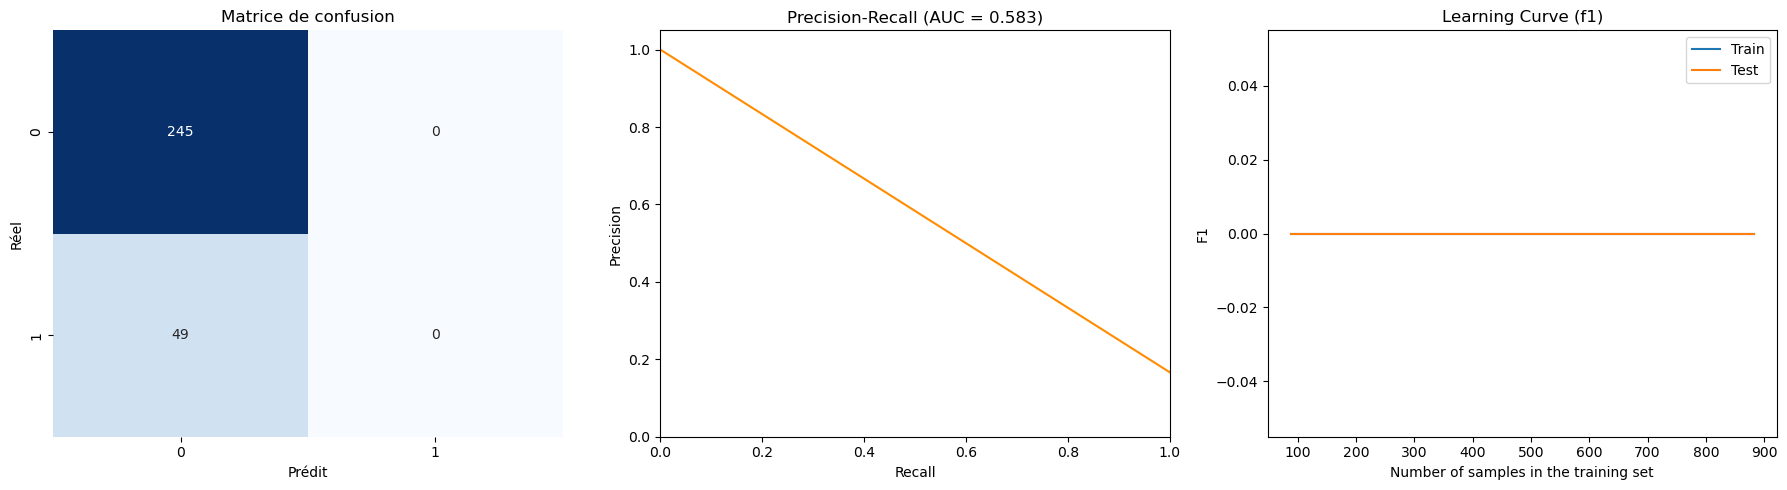

Linear

=== Métriques ===
balanced_accuracy: 0.7204
roc_auc          : 0.8496
pr_auc           : 0.6509

=== Classification report ===
              precision    recall  f1-score   support

           0      0.902     0.971     0.935       245
           1      0.767     0.469     0.582        49

    accuracy                          0.888       294
   macro avg      0.834     0.720     0.759       294
weighted avg      0.879     0.888     0.876       294



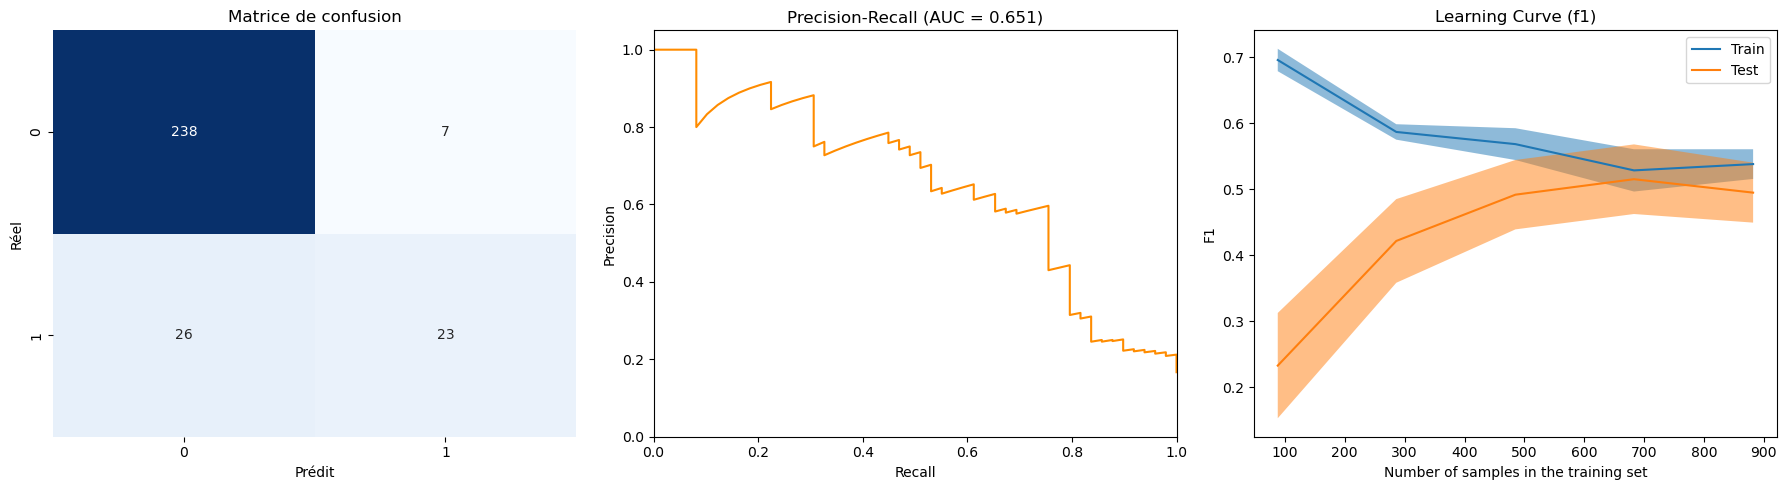

RandomForest

=== Métriques ===
balanced_accuracy: 0.6082
roc_auc          : 0.7973
pr_auc           : 0.5491

=== Classification report ===
              precision    recall  f1-score   support

           0      0.865     0.992     0.924       245
           1      0.846     0.224     0.355        49

    accuracy                          0.864       294
   macro avg      0.855     0.608     0.639       294
weighted avg      0.862     0.864     0.829       294



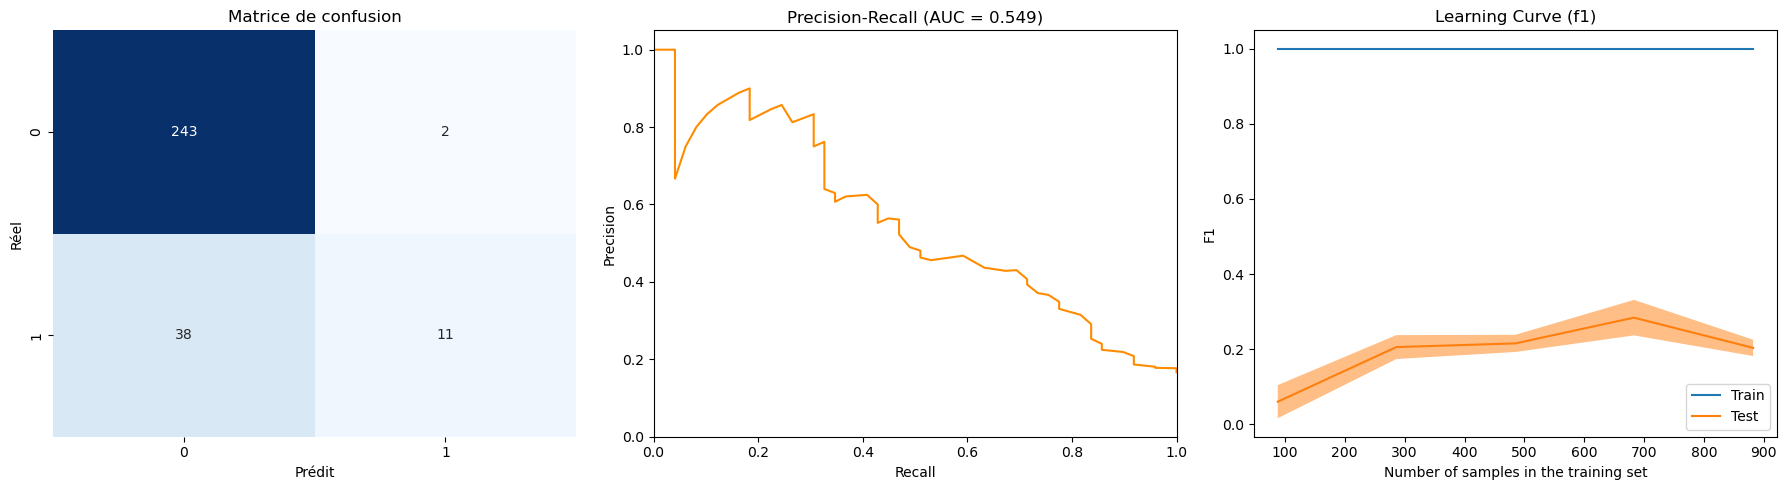

GradiantBoosting

=== Métriques ===
balanced_accuracy: 0.6510
roc_auc          : 0.8249
pr_auc           : 0.5254

=== Classification report ===
              precision    recall  f1-score   support

           0      0.880     0.955     0.916       245
           1      0.607     0.347     0.442        49

    accuracy                          0.854       294
   macro avg      0.743     0.651     0.679       294
weighted avg      0.834     0.854     0.837       294



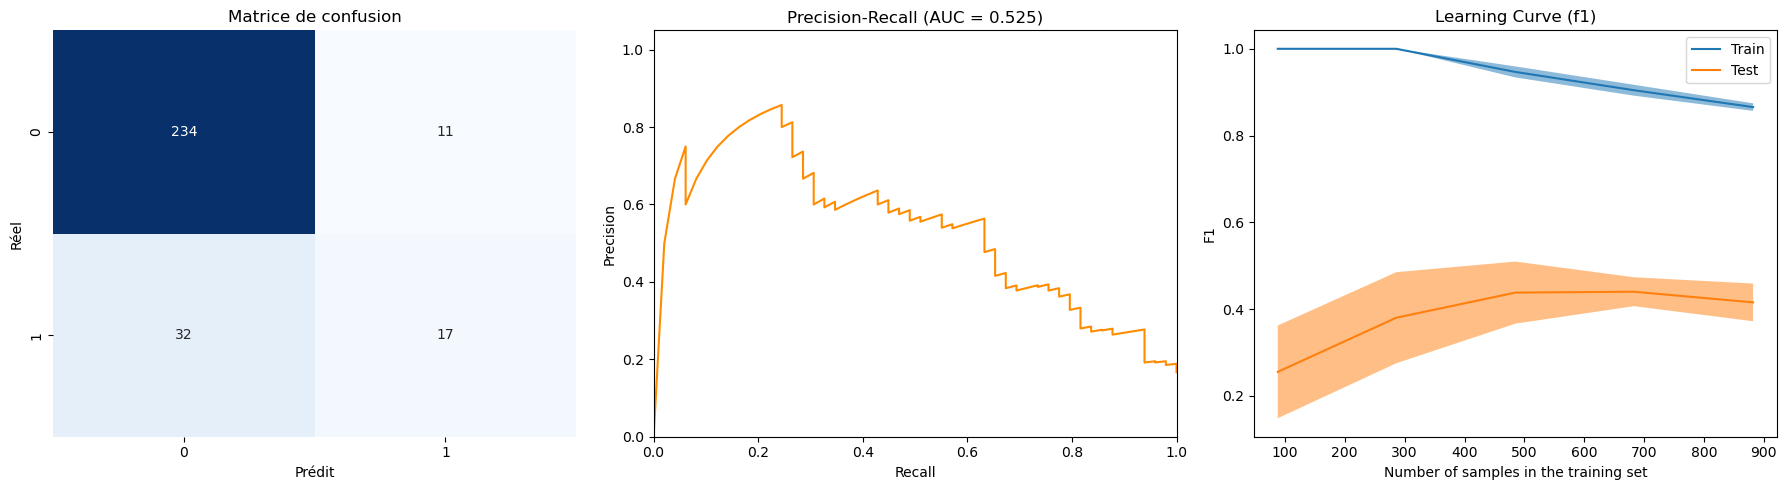

XGBoost

=== Métriques ===
balanced_accuracy: 0.6714
roc_auc          : 0.7965
pr_auc           : 0.5568

=== Classification report ===
              precision    recall  f1-score   support

           0      0.886     0.955     0.919       245
           1      0.633     0.388     0.481        49

    accuracy                          0.861       294
   macro avg      0.760     0.671     0.700       294
weighted avg      0.844     0.861     0.846       294



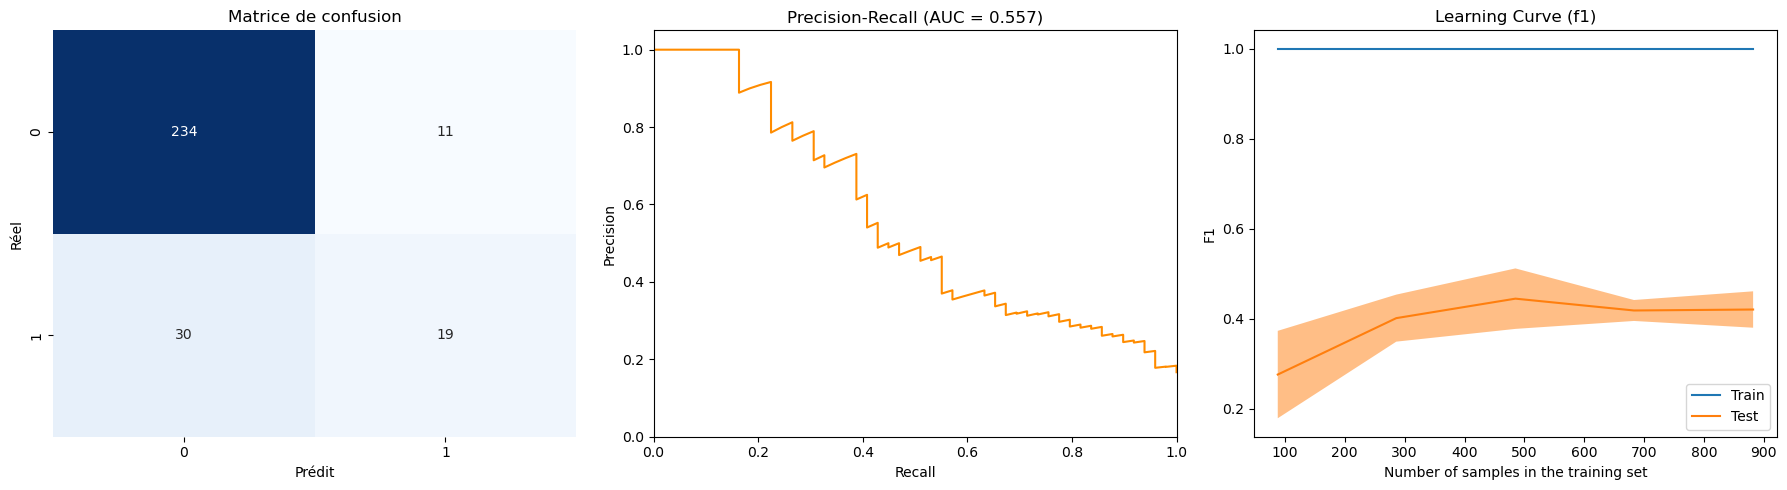

In [21]:
# Entrainnement et evaluation
for name, model in dict_of_models.items():
    print(name)
    evaluation(model, X_train, y_train, X_test, y_test)

* **NOUS OBSERVONS QUE :**
    * La régression logistique est étonnamment performante ici :
        - Meilleur ROC-AUC (0.87) = bonne capacité à distinguer les classes.
        - Meilleur F1 sur la classe 1 = équilibre entre précision et rappel.
        - PR-AUC solide, ce qui est crucial pour la classe minoritaire.

    * Gradient Boosting est proche, mais légèrement en retrait sur tous les fronts sauf le rappel (classe 1) où il bat le modèle linéaire de peu.
    * Random Forest est celui qui manque le plus les départs (rappel de 0.18) → il sur-prédit la classe dominante.